# Resources and credit:
- SSDD data download: https://github.com/TianwenZhang0825/LS-SSDD-v1.0-OPEN
- Detectron2 docs: https://detectron2.readthedocs.io/en/latest/index.html

# Installation of detectron2 and Imports
*Standard from Detectron2's docs*

*Restart after executing this cell*

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
exit(0)

1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



*Restart after executing this cell*

In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



# Registration of the custom dataset to detectron2

In [ ]:
# Function that retrieves a standard dataset compatible with detectron2
def get_dict(type):
  """ Returns a list[dict] containing information about the dataset """
  import pickle
  root = '/content/drive/MyDrive/SSDD/datasets/' + type + '/'
  with open(root + "standardDict.pkl", "rb") as input_file:
    return pickle.load(input_file)

In [ ]:
# Global paths
datasets = '/content/drive/MyDrive/SSDD/datasets/'

# Mount Google Drive (Import files from Google Drive in Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from detectron2.structures import BoxMode

pre = 'ssdd_'

# Register
for d in ["train", "test", "test_offshore", "test_inshore"]:
    DatasetCatalog.register(pre + d, lambda d=d: get_dict(d))
    MetadataCatalog.get(pre + d).set(thing_classes=["ship"])

In [ ]:
# Instances of metadata
train_metadata = MetadataCatalog.get(pre + 'train')
test_metadata = MetadataCatalog.get(pre + 'test')
test_offshore_metadata = MetadataCatalog.get(pre + 'test_offshore')
test_inshore_metadata = MetadataCatalog.get(pre + 'test_inshore')

# Training on a custom dataset
*Change Runtime to GPU before running*

In [ ]:
%cd /content/drive/MyDrive/SSDD/
output = '/content/drive/MyDrive/SSDD/'
model_name = "./ModelOutput/faster_rcnn_R_101_FPN_3x_1"

/content/drive/.shortcut-targets-by-id/1wPXpOTgpvbBJv06iD212UCxoZiCPIgEH/SSDD


In [ ]:
!pwd 

/content/drive/.shortcut-targets-by-id/1wPXpOTgpvbBJv06iD212UCxoZiCPIgEH/SSDD


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator  # To use the COCO validation evaluation during training. Otherwise no validation eval occurs.
# model zoo - https://github.com/facebookresearch/detectron2/tree/master/configs/COCO-Detection
# detectron2.config - https://detectron2.readthedocs.io/en/latest/modules/config.html
# Custom training https://github.com/facebookresearch/detectron2/blob/master/tools/train_net.py
# Custom training https://github.com/facebookresearch/detectron2/blob/master/tools/plain_train_net.py

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (pre + "train",)
cfg.DATASETS.TEST = (pre + 'test', pre + 'test_offshore', pre + 'test_inshore')  # must be the validation set
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
#cfg.SOLVER.MOMENTUM = 0.9
#cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.MAX_ITER = 30000   # 10 epochs * 6000 images / 2 images per batch = 30,000 iterations (adjust up if val mAP is still rising, adjust down if overfit)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # 128 is faster, and good enough for a toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1   # only has one class (ship). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False # allows training examples without annotations
cfg.TEST.EVAL_PERIOD = 3000  # runs an evaluation function every eval_period iterations, and after the last iteration (at the end of training)

In [ ]:
cfg.OUTPUT_DIR = model_name
cfg.OUTPUT_DIR

'./ModelOutput/faster_rcnn_R_101_FPN_3x_1'

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[01/25 20:56:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:10, 22.2MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.


[01/25 20:57:17 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:217: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


[01/25 20:57:27 d2.utils.events]:  eta: 4:02:46  iter: 19  total_loss: 0.7393  loss_cls: 0.7241  loss_box_reg: 0  loss_rpn_cls: 0.000189  loss_rpn_loc: 0  time: 0.4789  data_time: 0.0286  lr: 4.9953e-06  max_mem: 2545M
[01/25 20:57:36 d2.utils.events]:  eta: 4:00:05  iter: 39  total_loss: 0.6216  loss_cls: 0.5616  loss_box_reg: 0  loss_rpn_cls: 4.111e-05  loss_rpn_loc: 0  time: 0.4800  data_time: 0.0031  lr: 9.9902e-06  max_mem: 2545M
[01/25 20:57:47 d2.utils.events]:  eta: 4:05:56  iter: 59  total_loss: 0.3779  loss_cls: 0.3639  loss_box_reg: 0  loss_rpn_cls: 0.0002112  loss_rpn_loc: 0  time: 0.4912  data_time: 0.0035  lr: 1.4985e-05  max_mem: 2545M
[01/25 20:57:57 d2.utils.events]:  eta: 4:06:23  iter: 79  total_loss: 0.2083  loss_cls: 0.1942  loss_box_reg: 0  loss_rpn_cls: 5.562e-05  loss_rpn_loc: 0  time: 0.4925  data_time: 0.0029  lr: 1.998e-05  max_mem: 2545M
[01/25 20:58:07 d2.utils.events]:  eta: 4:06:19  iter: 99  total_loss: 0.1115  loss_cls: 0.1109  loss_box_reg: 0  loss_rpn

# TensorBoard

In [ ]:
# Look at training curves in tensorboard:
%cd ModelOutput/
%load_ext tensorboard
%tensorboard --logdir faster_rcnn_R_101_FPN_3x_1
%cd ..

# Evaluation using the trained model

To run inference using the trained model on the validation/test dataset, we first create a predictor using the model we just trained.

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
#cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5   # pg. 23 of Zhang et al.

predictor = DefaultPredictor(cfg)

## Visualization

We randomly select several samples to visualize the prediction results.

In [ ]:
#from detectron2.utils.visualizer import ColorMode

dataset_dicts = get_dict("test")   # must be "test", "test_offshore", "test_inshore"

# Filter out pics w/o annotations
dataset_dicts_anns = []
for i in dataset_dicts:
  if i['annotations'] != []:
    dataset_dicts_anns.append(i)

In [ ]:
def printImage(ann, metadata, predictor = None, predFlag = False):
  #from detectron2.utils.visualizer import Visualizer

  im = cv2.imread(ann["file_name"])
  v = Visualizer(im[:, :, ::-1], 
                 metadata=metadata, 
                 scale=0.5)
  
  if predFlag:
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  else:
    out = v.draw_dataset_dict(ann)
  
  image = out.get_image()[:, :, ::-1]

  return image

In [ ]:
os.makedirs(model_name + "/predImages", exist_ok=True)  # Make a directory for output images

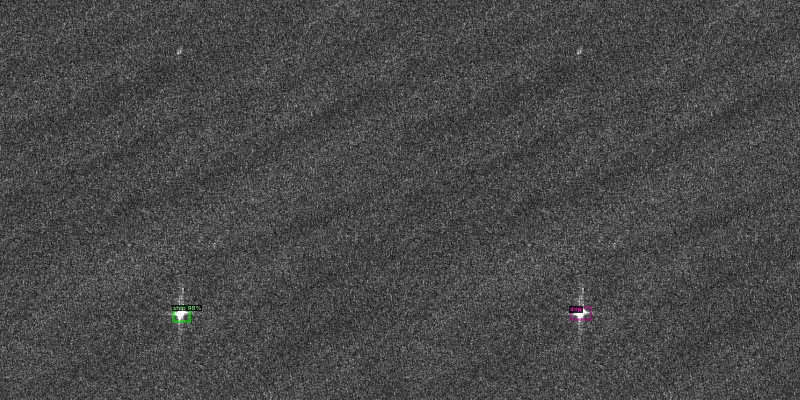

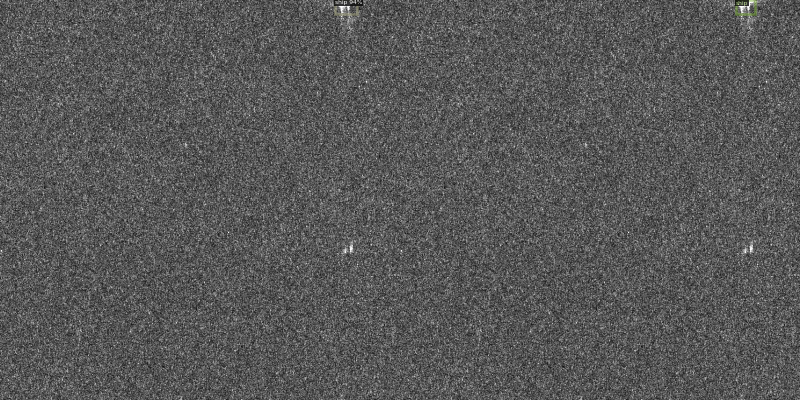

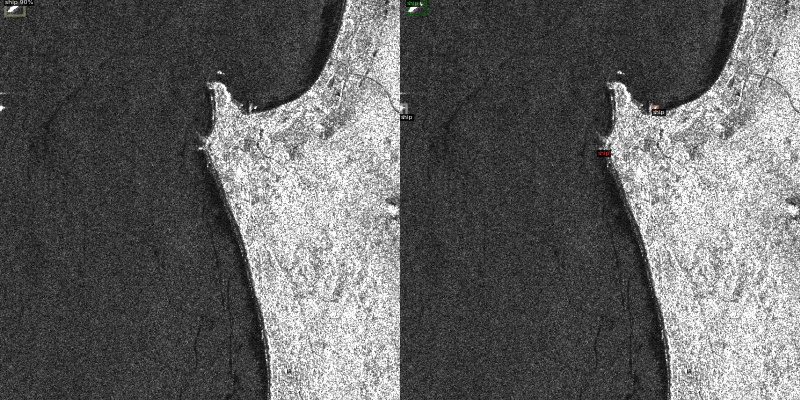

In [ ]:
from cv2 import hconcat
#random.seed(2)

num_samples = 3

for d in random.sample(dataset_dicts_anns, num_samples):
  image1 = printImage(d, test_metadata, predictor, True)  # Prediction
  image2 = printImage(d, test_metadata, False)  # Ground truth
  image3 = hconcat([image1, image2])

  cv2_imshow(image3)  # display an image
  cv2.imwrite(model_name + '/predImages/' + str(d["image_id"] + '.jpg'), image3)  # save an image

# Prediction

We can also evaluate its performance using AP metric implemented in COCO API.

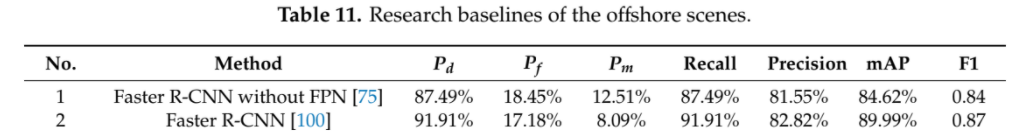

In [ ]:
#val = './datasets/test/'

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# test_offshore
evaluator = COCOEvaluator('ssdd_test_offshore', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test_offshore')

inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way to evaluate the model is to use `trainer.test`

[01/26 01:25:23 d2.evaluation.coco_evaluation]: 'ssdd_test_offshore' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[01/26 01:25:23 d2.data.datasets.coco]: Converting annotations of dataset 'ssdd_test_offshore' to COCO format ...)
[01/26 01:25:42 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[01/26 01:25:43 d2.data.datasets.coco]: Conversion finished, #images: 2234, #annotations: 1495
[01/26 01:25:43 d2.data.datasets.coco]: Caching COCO format annotations at './ModelOutput/faster_rcnn_R_101_FPN_3x_1/ssdd_test_offshore_coco_format.json' ...
[01/26 01:25:43 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    ship    | 1495         |
|            |              |
[01/26 01:25:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[0

In [ ]:
# test
evaluator = COCOEvaluator('ssdd_test', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test')

inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way to evaluate the model is to use `trainer.test`

[01/26 01:37:44 d2.evaluation.coco_evaluation]: 'ssdd_test' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[01/26 01:37:44 d2.data.datasets.coco]: Converting annotations of dataset 'ssdd_test' to COCO format ...)
[01/26 01:37:44 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[01/26 01:37:45 d2.data.datasets.coco]: Conversion finished, #images: 3000, #annotations: 2378
[01/26 01:37:45 d2.data.datasets.coco]: Caching COCO format annotations at './ModelOutput/faster_rcnn_R_101_FPN_3x_1/ssdd_test_coco_format.json' ...
[01/26 01:37:45 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    ship    | 2378         |
|            |              |
[01/26 01:37:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/26 01:37:45 d2.data.commo

In [ ]:
# test_inshore
evaluator = COCOEvaluator('ssdd_test_inshore', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test_inshore')

inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way to evaluate the model is to use `trainer.test`

[01/26 01:49:47 d2.evaluation.coco_evaluation]: 'ssdd_test_inshore' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[01/26 01:49:47 d2.data.datasets.coco]: Converting annotations of dataset 'ssdd_test_inshore' to COCO format ...)
[01/26 01:49:58 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[01/26 01:49:58 d2.data.datasets.coco]: Conversion finished, #images: 766, #annotations: 883
[01/26 01:49:58 d2.data.datasets.coco]: Caching COCO format annotations at './ModelOutput/faster_rcnn_R_101_FPN_3x_1/ssdd_test_inshore_coco_format.json' ...
[01/26 01:49:58 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    ship    | 883          |
|            |              |
[01/26 01:49:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/26 